In [1]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import pickle as pk
import os.path
import pandas as pd
from collections import (defaultdict,Counter)
import time
import matplotlib.pyplot as plt


In [2]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

In [3]:
#Here, we create a dictionary out of the dataframe that has as a key the exposures and as 
#values the set of the genes that they perturb
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])
        

        

In [4]:
#Here, we remove the elements that do not perturb any genes:       
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)           
    else:
        pass
 
print("The number of exposures is %s" %len(chem_gene_cleaned))
print("The total number of perturbed genes is %s" %len(set(tot_gene_list)))

The number of exposures is 9887
The total number of perturbed genes is 25580


In [5]:
#The number of genes is pretty high, because there are included also: pseudogenes, lncRNA,
#miRNA and other non coding elements

In [5]:
#Let's build also the vice-versa: the gene-chem dictionary
gene_chem = {}
for i,v in chem_homo.iterrows():
    try:
        gene_chem[v["GeneSymbol"]] |= {v["ChemicalID"]}
    except KeyError as e:
        gene_chem[v["GeneSymbol"]] = set([v["ChemicalID"]])

In [6]:
gene_chem_cleaned={}
for k,v in gene_chem.items():
    if len(v)!=0:
        gene_chem_cleaned[k]=v
    else:
        pass
    

In [28]:
chem_vocabolary = pd.read_csv("input/CTD/CTD_chemicals_cleaned.txt",delimiter= '\t',
           skipinitialspace=True)
chem_voc_dict = {}
for i,v in chem_vocabolary.iterrows():
    try:
        chem_voc_dict[v["ChemicalID"]] = v["ParentIDs"].split("|")
    except:
        chem_voc_dict[v["ChemicalID"]] = v["ParentIDs"]


In [29]:
from collections.abc import Mapping
# Empty directed graph
G = nx.DiGraph()

for k in chem_voc_dict.keys():
    try:
        for v in chem_voc_dict[k]:
            G.add_edge(k, v)
    except:
        G.add_edge(k,"D")


In [30]:
#Here, we group all the chemicals in 12 categories, obtained extrapoling the
#second layer of the chemical ontology
classes_list=[]
for i in G.nodes():
    if len(nx.predecessor(G, i))==2:
        classes_list.append(i)

In [31]:
#Let's clean the list from the nan elements
classes_list_cleaned = [x for x in classes_list if str(x) != 'nan']

In [7]:
#Here, we import the merged PPI
ppi = pd.read_csv("input/PPI/autocore_symbol_lcc.csv",delimiter= ',',
           skipinitialspace=True)

In [8]:
G_ppi = nx.from_pandas_edgelist(ppi, 'symbol1', 'symbol2')

In [9]:
G_ppi_lcc = G_ppi.subgraph(max(nx.connected_components(G_ppi), key=len))  # extract lcc graph
print(G_ppi_lcc.number_of_nodes())
print(G_ppi_lcc.number_of_edges())

18815
482935


In [8]:
#Here, we filter the exposures, considering only the ones that target proteins
#in the PPI
chem_gene_dictio_cleaned_ppi={}
for k,v in chem_gene_cleaned.items():
    new_list=[]
    for gene in v:
        if gene in G_ppi_lcc.nodes():
            new_list.append(gene)
        else:
            pass
    if len(new_list)>0:
        chem_gene_dictio_cleaned_ppi[k]=new_list
    else:
        pass

bipartite_G = nx.Graph()
exposures_list = []
genes_list = []
for k,v in chem_gene_dictio_cleaned_ppi.items():
    exposures_list.append(k)
    for gene in v:
        genes_list.append(gene)   
for gene in set(genes_list):
    bipartite_G.add_node(gene,s="^", bipartite='gene')   
for exposure in set(exposures_list):
    bipartite_G.add_node(exposure,s="o", bipartite='exposure')
    for genes in chem_gene_dictio_cleaned_ppi[exposure]:
        bipartite_G.add_edges_from([(exposure,genes)])

In [9]:
nx.bipartite.is_bipartite(bipartite_G)

True

In [10]:
bipartite_G.number_of_nodes()

27875

In [11]:
bipartite_G.number_of_edges()

537985

In [21]:
print("The number of considered genes is %s" %len(set(genes_list)))

The number of considered genes is 18023


In [12]:
gene_chem_cleaned_ppi={}

for gene, exp_list in gene_chem_cleaned.items():
    if gene in G_ppi_lcc.nodes():
        gene_chem_cleaned_ppi[gene]=exp_list
    else:
        pass
    
    

In [13]:
import scipy
gene_degreeppi=[]
gene_numexp=[]
for gene,explist in gene_chem_cleaned_ppi.items():
    gene_degreeppi.append(nx.degree(G_ppi_lcc,gene))
    gene_numexp.append(len(explist))

print(scipy.stats.pearsonr(gene_degreeppi,gene_numexp))  # Pearson's r
print(scipy.stats.spearmanr(gene_degreeppi,gene_numexp)) # Spearman's rho

PearsonRResult(statistic=0.23729929599830776, pvalue=3.928859999516407e-229)
SignificanceResult(statistic=0.3904600122770663, pvalue=0.0)


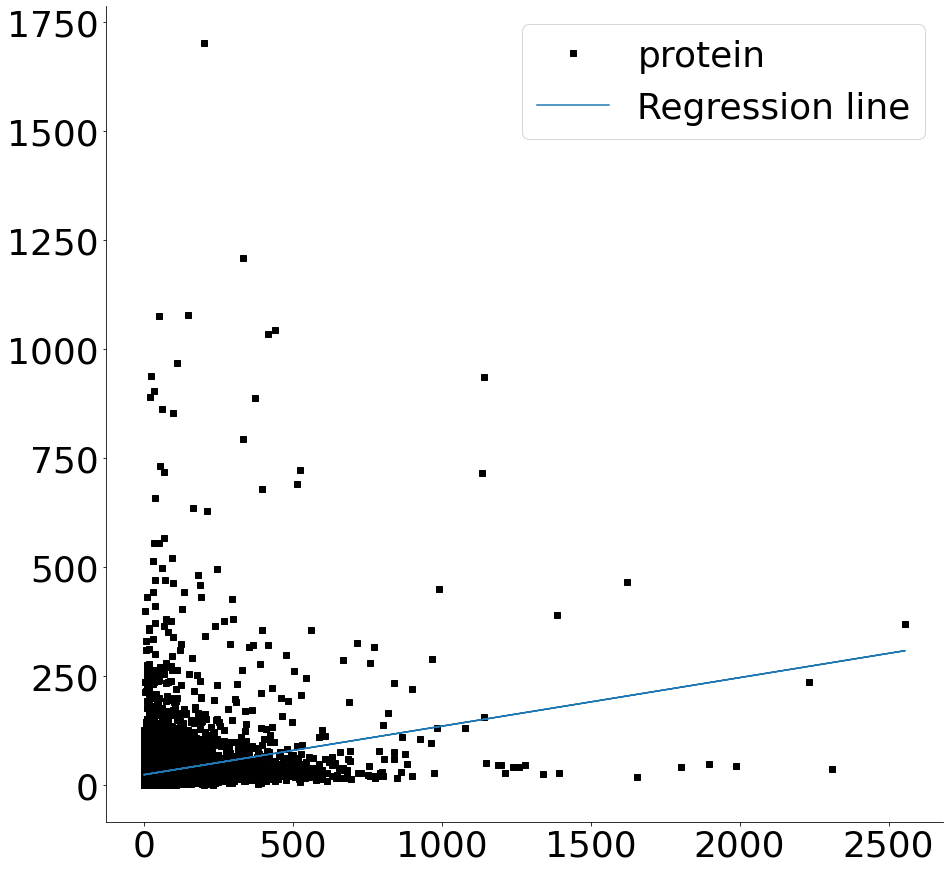

In [17]:
import scipy
from matplotlib.pyplot import figure
from scipy import stats

fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(gene_degreeppi, gene_numexp)

ax.plot(gene_degreeppi,gene_numexp, linewidth=0, marker='s',c='k', label='protein')
y=[]
for i in gene_degreeppi:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(gene_degreeppi, y, label=line)
#ax.set_xlabel('Degree in the PPI', fontsize=18)
#ax.set_ylabel('Number of exposures',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

# plt.title('Correlation between Resnik and Genetic overlap in %s' %met )
ax.legend(facecolor='white',fontsize=36)
plt.show()

In [14]:
#Let's group in 5 boxplots sorted by their degree
#Let's create a dataframe that contains these values
column_names = ["N_exp", "Degree"]

deg_nexp_df = pd.DataFrame(columns = column_names)
deg_nexp_df['N_exp']=gene_numexp
deg_nexp_df['Degree']=gene_degreeppi

deg_nexp_df_sort_by_degree=deg_nexp_df.sort_values("Degree")

cat_list=[]
for i in range(len(deg_nexp_df_sort_by_degree)):
    if i<len(deg_nexp_df_sort_by_degree)/5:
        cat_list.append("1st quintile")
    elif i>len(deg_nexp_df_sort_by_degree)/5 and i<2*len(deg_nexp_df_sort_by_degree)/5:
        cat_list.append("2nd quintile")
    elif i>2*len(deg_nexp_df_sort_by_degree)/5 and i<3*len(deg_nexp_df_sort_by_degree)/5:
        cat_list.append("3rd quintile")
    elif i>3*len(deg_nexp_df_sort_by_degree)/5 and i<4*len(deg_nexp_df_sort_by_degree)/5:
        cat_list.append("4th quintile")
    else:
        cat_list.append("5th quintile")
        
deg_nexp_df_sort_by_degree["Group"]=cat_list

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_36792/2016077031.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([round(i,2) for i in ax.get_yticks()], size = 36)


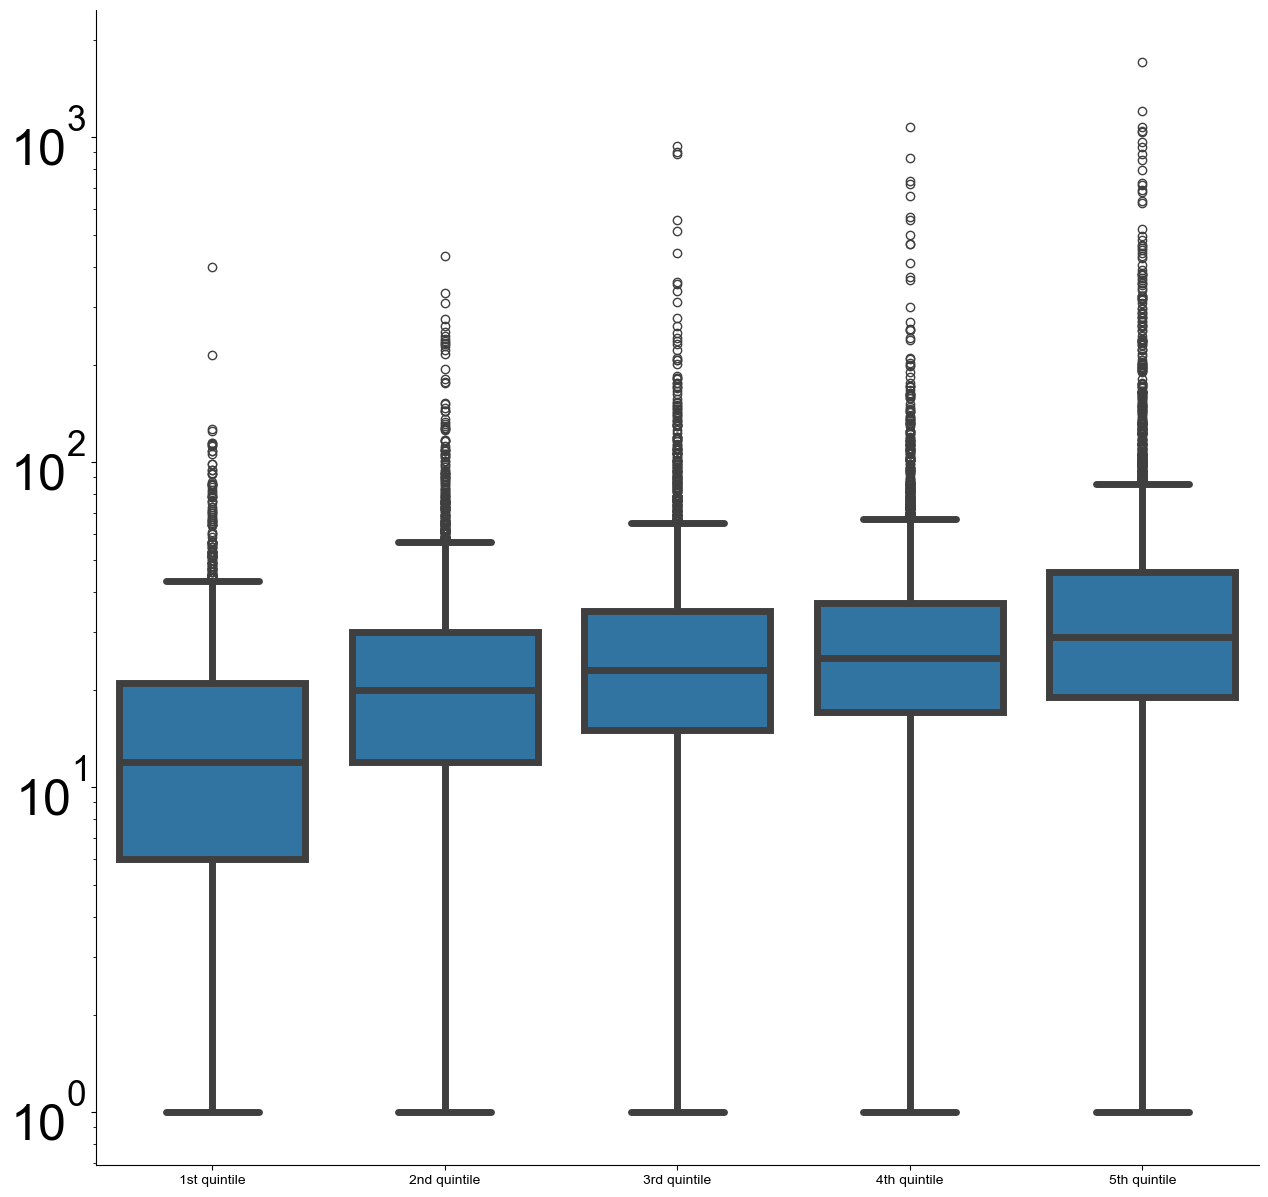

In [15]:
#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
fig, ax = plt.subplots(figsize=(15, 15))

sns.set_style('white')
sns.set(style="white",font_scale = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
g=sns.boxplot(data=deg_nexp_df_sort_by_degree,x="Group", y="N_exp",order=['1st quintile','2nd quintile', '3rd quintile','4th quintile',
 '5th quintile'],linewidth=5)
plt.xlabel('',fontsize=22)
plt.ylabel('', fontsize=22)
#plt.xticks([], fontsize=22)
ax.grid(False)
ax.set_yticklabels([round(i,2) for i in ax.get_yticks()], size = 36)
#ax.set_xticklabels(ax.get_xticks(), size = 36)
g.set_yscale("log")
#plt.savefig('output/Figures/Fig3B.pdf',format='pdf',dpi=300, bbox_inches = "tight")


plt.show()

In [16]:

# Make a clean copy
df_box = deg_nexp_df_sort_by_degree.copy()

# Ensure correct ordering
order = ['1st quintile',
         '2nd quintile',
         '3rd quintile',
         '4th quintile',
         '5th quintile']

df_box["Group"] = pd.Categorical(df_box["Group"],
                                 categories=order,
                                 ordered=True)

# Add numeric group index (useful for reviewers)
df_box["Group_index"] = df_box["Group"].cat.codes + 1

# Add log10 version (since plot uses log scale)
df_box["log10_N_exp"] = np.log10(df_box["N_exp"])

# Keep only relevant columns
df_box_export = df_box[["Group",
                        "Group_index",
                        "N_exp",
                        "log10_N_exp"]]

print("Total observations:", len(df_box_export))
print(df_box_export.groupby("Group").size())

# ----------------------------
# SAVE TO EXCEL
# ----------------------------

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_box_export.to_excel(writer,
                           sheet_name="Fig3B",
                           index=False)

print("Boxplot source data saved successfully.")

Total observations: 18023
Group
1st quintile    3605
2nd quintile    3605
3rd quintile    3604
4th quintile    3605
5th quintile    3604
dtype: int64


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_36792/3707833684.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_box_export.groupby("Group").size())


Boxplot source data saved successfully.


In [17]:




print(scipy.stats.mannwhitneyu(deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='1st quintile']['N_exp'].tolist(), deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='2nd quintile']['N_exp'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='1st quintile']['N_exp'].tolist(), deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='3rd quintile']['N_exp'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='1st quintile']['N_exp'].tolist(), deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='4th quintile']['N_exp'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='1st quintile']['N_exp'].tolist(), deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='5th quintile']['N_exp'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='2nd quintile']['N_exp'].tolist(), deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='3rd quintile']['N_exp'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='2nd quintile']['N_exp'].tolist(), deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='4th quintile']['N_exp'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='2nd quintile']['N_exp'].tolist(), deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='5th quintile']['N_exp'].tolist(), use_continuity=True, alternative='two-sided'))


print(scipy.stats.mannwhitneyu(deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='3rd quintile']['N_exp'].tolist(), deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='4th quintile']['N_exp'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='3rd quintile']['N_exp'].tolist(), deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='5th quintile']['N_exp'].tolist(), use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='4th quintile']['N_exp'].tolist(), deg_nexp_df_sort_by_degree[deg_nexp_df_sort_by_degree['Group']=='5th quintile']['N_exp'].tolist(), use_continuity=True, alternative='two-sided'))



MannwhitneyuResult(statistic=4252373.0, pvalue=1.4816184563223326e-142)
MannwhitneyuResult(statistic=3428533.5, pvalue=2.656620944640691e-264)
MannwhitneyuResult(statistic=3038017.0, pvalue=0.0)
MannwhitneyuResult(statistic=2483973.0, pvalue=0.0)
MannwhitneyuResult(statistic=5503155.5, pvalue=2.5154526315110236e-29)
MannwhitneyuResult(statistic=5026032.5, pvalue=2.51274711250499e-62)
MannwhitneyuResult(statistic=4218498.5, pvalue=1.297666721572126e-146)
MannwhitneyuResult(statistic=6014537.0, pvalue=4.9513724643969e-08)
MannwhitneyuResult(statistic=5124020.5, pvalue=2.66864604684785e-54)
MannwhitneyuResult(statistic=5573351.5, pvalue=1.5075442800920064e-25)


In [98]:
#Furthermore, I will compute a z-score distribution of the median degree of the perturbed genes, comparing with random
#genest of the same size

import math
exp_mediandegree_zscore={}

for exp,geneset in chem_gene_dictio_cleaned_ppi.items():
    gene_degreeppi=[]
    for gene in geneset:
        gene_degreeppi.append(nx.degree(G_ppi_lcc,gene))   
    median_gene=np.median(gene_degreeppi)
        
    S = 1000
    median_degree_rnd=[]
    for s in range(S):
        gene_degreeppi_random=[]
        gene_sample = rd.sample(G_ppi_lcc.nodes(),len(geneset))
        for gene in gene_sample:
            gene_degreeppi_random.append(nx.degree(G_ppi_lcc,gene)) 
        median_gene_random=np.median(gene_degreeppi_random)
        median_degree_rnd.append(median_gene_random)
    mu = np.mean(median_degree_rnd)
    std = np.std(median_degree_rnd)

    z = round(((median_gene-mu)/std),3)

    exp_mediandegree_zscore[exp]=z

In [99]:
len(exp_mediandegree_zscore)

9852

In [104]:
z_zscore_list=[]
for chem,z_score in exp_mediandegree_zscore.items():
    z_zscore_list.append(float(z_score))
print(np.mean(z_zscore_list))

3.53590712545676


In [100]:
with open('output/exp_mediandegree_zscore.pickle', 'wb') as handle:
    pk.dump(exp_mediandegree_zscore, handle, protocol=pk.HIGHEST_PROTOCOL)

In [17]:
with open('output/exp_mediandegree_zscore.pickle', 'rb') as handle:
    exp_mediandegree_zscore = pk.load(handle)

In [4]:
notsignificantdegreeexp_list=[]
for k,v in exp_mediandegree_zscore.items():
    if float(v)<2:
        notsignificantdegreeexp_list.append(k)
print(len(notsignificantdegreeexp_list))

5888


In [5]:
print(len(notsignificantdegreeexp_list)/len(exp_mediandegree_zscore))

0.5976451481932602


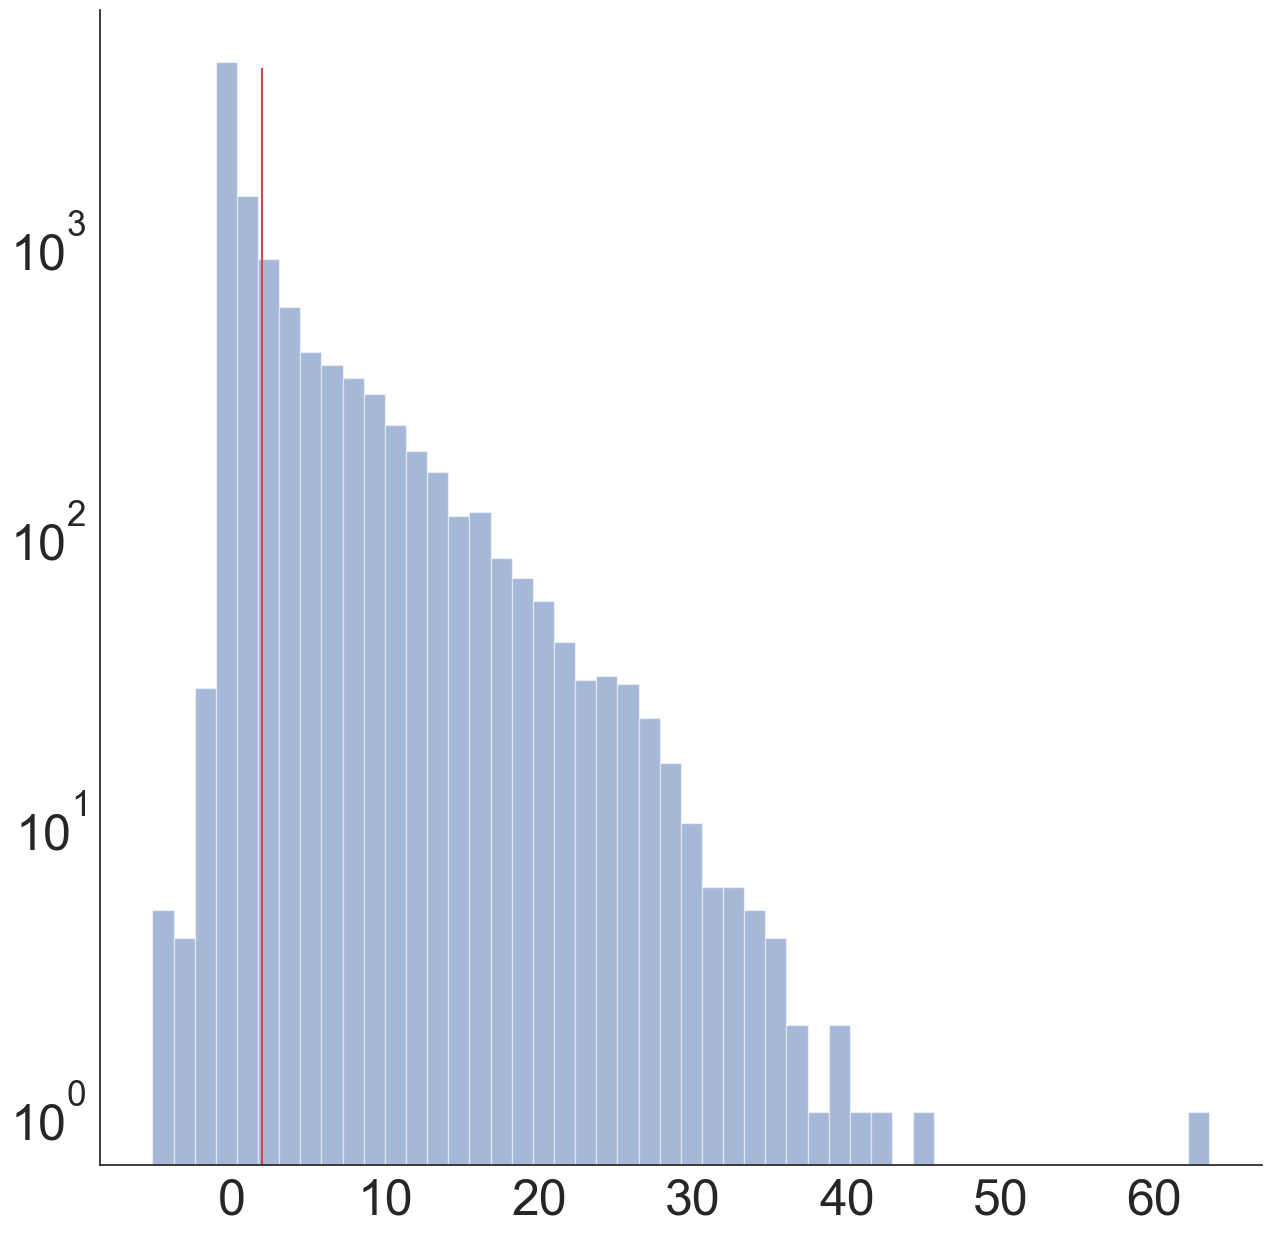

In [18]:
exp_mediandegree_zscore_cleaned=[]
for z in exp_mediandegree_zscore.values():
    if str(z)!="nan":
        exp_mediandegree_zscore_cleaned.append(z)
        
fig, ax = plt.subplots(figsize=(15,15))
plt.hist(exp_mediandegree_zscore_cleaned, bins=50, alpha=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.xlabel('z-score',fontsize=22)
#plt.ylabel('Frequency', fontsize=22)
plt.yscale('log')
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36)
plt.vlines(x=2,ymin=0,ymax=4000,color='r',label='statistically significance')
#plt.title('Distribution of median degree z-score of geneset perturbed by each exposures', fontsize=28)
#plt.savefig('output/Figures/Fig3C.pdf',format='pdf',dpi=300, bbox_inches = "tight")


In [19]:

# ----------------------------
# Clean data (same as plot)
# ----------------------------
z_values = [
    z for z in exp_mediandegree_zscore.values()
    if str(z) != "nan"
]

z_array = np.array(z_values)

print("Total observations:", len(z_array))

# ----------------------------
# Compute histogram (50 bins)
# ----------------------------
counts, bin_edges = np.histogram(z_array, bins=50)

# Assign each value to its bin
bin_indices = np.digitize(z_array, bin_edges, right=False) - 1

# Fix edge case for rightmost value
bin_indices[bin_indices == 50] = 49

# Build full dataframe
df_hist_full = pd.DataFrame({
    "z_score": z_array,
    "significant_(z>=2)": z_array >= 2,
    "bin_index": bin_indices,
    "bin_left": bin_edges[bin_indices],
    "bin_right": bin_edges[bin_indices + 1],
    "bin_count": counts[bin_indices]
})

# Add log10 count (for log y-axis)
df_hist_full["log10_bin_count"] = np.where(
    df_hist_full["bin_count"] > 0,
    np.log10(df_hist_full["bin_count"]),
    np.nan
)

print("Significant exposures:", sum(z_array >= 2))

# ----------------------------
# SAVE TO EXCEL
# ----------------------------

out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(out_file,
                    engine="openpyxl",
                    mode="a",
                    if_sheet_exists="replace") as writer:

    df_hist_full.to_excel(writer,
                          sheet_name="Fig3C",
                          index=False)

print("Histogram source data (single sheet) saved successfully.")

Total observations: 9852
Significant exposures: 3964
Histogram source data (single sheet) saved successfully.
